In [70]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, when, max, min
from pyspark.sql.types import FloatType
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.appName("AmazonBooksAnalysis").getOrCreate()

In [33]:
# 1. Прочитайте CSV файл spark.read.csv()

amazon_data = spark.read.csv("bestsellers with categories.csv", header=True, inferSchema=True)

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643|   11|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735|   30|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699|   15|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

In [6]:
# 2. Вивести схему даних за допомогою PrintSchema.

amazon_data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Genre: string (nullable = true)



In [9]:
# 3. Вивести назви стовпців і типи даних за допомогою dtypes

amazon_data.dtypes

[('Name', 'string'),
 ('Author', 'string'),
 ('User Rating', 'double'),
 ('Reviews', 'int'),
 ('Price', 'int'),
 ('Year', 'int'),
 ('Genre', 'string')]

In [11]:
# 4. Виведіть перші п'ять рядків (використовується метод head)

amazon_data.head(5)

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction'),
 Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating=4.6, Reviews=2052, Price=22, Year=2011, Genre='Fiction'),
 Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating=4.7, Reviews=18979, Price=15, Year=2018, Genre='Non Fiction'),
 Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating=4.7, Reviews=21424, Price=6, Year=2017, Genre='Fiction'),
 Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating=4.8, Reviews=7665, Price=12, Year=2019, Genre='Non Fiction')]

In [12]:
# 5. Вивести перший рядок за допомогою first()

amazon_data.first()

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating=4.7, Reviews=17350, Price=8, Year=2016, Genre='Non Fiction')

In [13]:
# 6. Зробіть опис датасету за допомогою describe()

amazon_data.describe()

DataFrame[summary: string, Name: string, Author: string, User Rating: string, Reviews: string, Price: string, Year: string, Genre: string]

In [15]:
# 7. Виведіть список стовпців за допомогою columns()

amazon_data.columns

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']

In [16]:
# 8.  Виведіть загальну кількість рядків даних за допомогою count()

amazon_data.count()

550

In [24]:
# 9. Перевірте, чи у всіх рядків вистачає даних. Якщо є пропуски, замінить 
# їх на NaN, потім тип даних на числовий.

if amazon_data.dropna().count() == amazon_data.count():
    print("There are no missing values in the DataFrame.")
else:
    print("There were missing values in the DataFrame.")


There are no missing values in the DataFrame.


In [34]:
# 10. Замініть комірки з пропущеними значенями на середні за стовпцем. І тип даних на float.
# Про скільки книг зберігає дані датасет?

# пропусків немає

num_books = amazon_data.count()
print(f"\nThe dataset contains information about {num_books} books.")


The dataset contains information about 550 books.


In [36]:
# 11. Змініть назви всіх колонок: назва з маленької букви, без пробілів через підкреслення.
# 12. df.columns = ['name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre']

new_column_names = [col(column).alias(column.lower().replace(' ', '_')) for column in amazon_data.columns]
amazon_data = amazon_data.select(*new_column_names)

amazon_data.show(5)

+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                name|              author|user_rating|reviews|price|year|      genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|    8|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052|   22|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979|   15|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|    6|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665|   12|2019|Non Fiction|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
only showing top 5 rows



In [41]:
# 13. Знайдіть автора з найвищим рейтингом.

best_author = (
    amazon_data
    .groupBy("author")
    .agg(max("user_rating").alias("max_rating"))
    .orderBy(col("max_rating").desc())
    .limit(1)
)

best_author.show()

+-----------+----------+
|     author|max_rating|
+-----------+----------+
|Sarah Young|       4.9|
+-----------+----------+



In [45]:
# 14. Знайдіть автора з найнижчим рейтингом.

worst_author = (
    amazon_data
    .groupBy("author")
    .agg(min("user_rating").alias("min_rating"))
    .orderBy(col("min_rating").asc())
    .limit(1)
)

worst_author.show()

+------------+----------+
|      author|min_rating|
+------------+----------+
|J.K. Rowling|       3.3|
+------------+----------+



In [49]:
# 15. Знайдіть автора, що має найбільшу кількіть рецензій.

max_reviews = (
    amazon_data
    .groupBy("author")
    .agg(max("reviews").alias("max_reviews"))
    .orderBy(col("max_reviews").desc())
    .limit(1)
)

max_reviews.show()

+-----------+-----------+
|     author|max_reviews|
+-----------+-----------+
|Delia Owens|      87841|
+-----------+-----------+



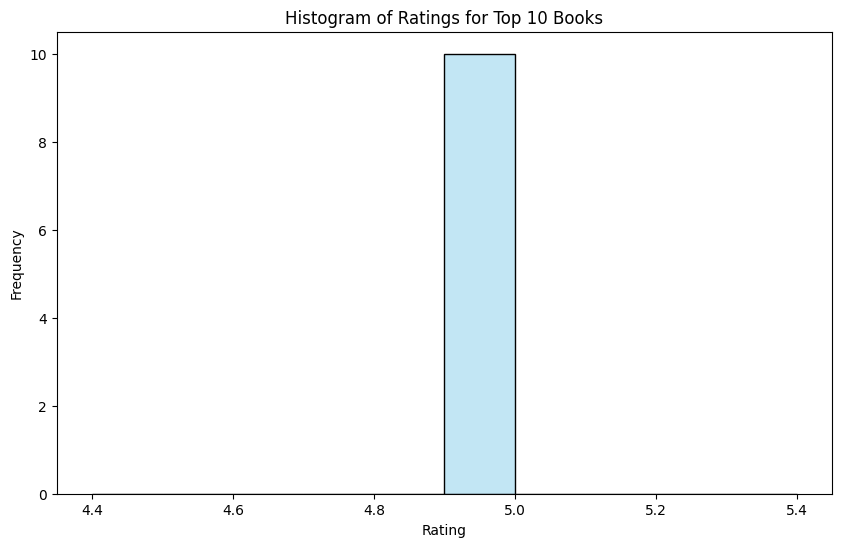

In [61]:
# 16. Побудуйте гістограму рейтингу 10 найкращих книг (відібрати книги з найбільшим рейтингом).

top_10_books = (
    amazon_data
    .orderBy(col("user_rating").desc())
    .limit(10)
)

top_10_books_pd = top_10_books.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(top_10_books_pd['user_rating'], bins=10, kde=True, color='skyblue')
plt.title('Histogram of Ratings for Top 10 Books')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


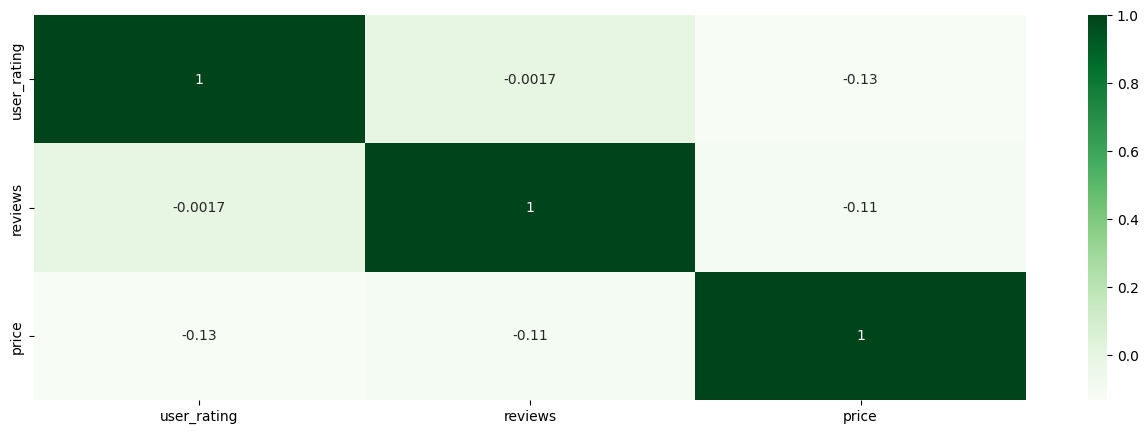

In [72]:
# 17. Побудуйте матрицю кореляції для стовпчиків 'user_rating', 'reviews', 'price'.

desired_columns = ['user_rating', 'reviews', 'price']
selected_data = amazon_data.select(desired_columns)

assembler = VectorAssembler(inputCols=desired_columns, outputCol="features")
selected_data = assembler.transform(selected_data)

matrix = Correlation.corr(selected_data, 'features').collect()[0][0]
corr_matrix = matrix.toArray().tolist()

corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=desired_columns, index=desired_columns)

for col in numeric_variables:
    corr_matrix_df[col] = corr_matrix_df[col].astype(float)

plt.figure(figsize=(16, 5))
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values, cmap="Greens", annot=True)
plt.show()